In [2]:
import numpy as np #library to handle data in a vectorized manner
import pandas as pd #library for data analysis
import json #library for json file
!pip install geopy
from geopy.geocoders import Nominatim #convert address to longitude and latitude
import requests #library to handle requests
from pandas.io.json import json_normalize #convert json file to pandas data frame
#matplotlib plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans #for clustering
!conda install -c conda-forge folium=0.5.0 --yes 
import folium #library for plotting maps
print('Libraries imported')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                       

Importing lib to get data in required format

In [3]:
import requests
wiki_url=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text #retrieve the text of wiki_url

Use the BeautifulSoup package or any other way you are comfortable with to transform the data in the table on the Wikipedia page into the above pandas dataframe

In [4]:
!pip install BeautifulSoup4
from bs4 import BeautifulSoup
soup = BeautifulSoup(wiki_url,'html.parser')
print(soup.prettify()) #library to get table from wiki_url

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"219b0089-02a0-4c0a-8975-c018874a2587","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":969510799,"wgRevisionId":969510799,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Communications in Ontario","Postal codes in Canada","Toron

By observation we can see that the tabular data is availabe in table and belongs to class="wikitable sortable"So let's extract only table

In [5]:
table = soup.find('table',{'class':'wikitable sortable'})
print(table.tr.text) #TABLE


Postal Code

Borough

Neighbourhood



FIND ALL ROWS IN A TABLE AND CONVERT IT INTO PANDAS DATAFRAME

In [6]:
table_rows = table.find_all('tr') #FIND ALL ROWS IN TABlE

In [45]:
data = []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])

df = pd.DataFrame(data, columns=['PostalCode', 'Borough', 'Neighborhood'])
df = df[~df['PostalCode'].isnull()]  # to filter out bad rows

In [46]:
df.head()

,PostalCode,Borough,Neighborhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Only processing the cells that have an assigned borough. Ignoring the cells with a borough that is Not assigned. Droping row where borough is "Not assigned"

In [47]:
indexNames = df[ df['Borough'] =='Not assigned'].index

df.drop(indexNames , inplace=True)
df.head()

,PostalCode,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

In [48]:
df.loc[df['Neighborhood'] =='Not assigned' , 'Neighborhood'] = df['Borough']
df.head(10)

,PostalCode,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
9,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
10,M1B,Scarborough,"Malvern, Rouge"
12,M3B,North York,Don Mills
13,M4B,East York,"Parkview Hill, Woodbine Gardens"
14,M5B,Downtown Toronto,"Garden District, Ryerson"


Rows will be same postalcode will combined into one row with the neighborhoods separated with a comma

In [49]:
df_new = df.groupby(['PostalCode','Borough'], sort=False).agg( ', '.join)
df_new=df_new.reset_index()
df_new.head(15)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [50]:
df.shape

(103, 3)

READ GEOSPATIAL DATA AND CREATE THE NEW TORNOTO DATAFRAME USING PANDAS

In [51]:
df_geo=pd.read_csv('http://cocl.us/Geospatial_data')
df_geo.columns = ['PostalCode', 'Latitude', 'Longitude']
df_geo.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [69]:
df2 = pd.merge(df_new,
                 df_geo[['PostalCode','Latitude', 'Longitude']])
df2.head(15)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


Explore and cluster the neighborhoods in Tornoto

In [53]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="Tornoto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the City of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the City of Toronto are 43.6534817, -79.3839347.


In [55]:
Tornoto_map=folium.Map(location=[latitude,longitude],zoom_start=10)
for lat, lng, borough, Neighbourhood in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Borough'], Toronto_df['Neighborhood']):
    label = '{}, {}'.format(Neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(Tornoto_map)  

Tornoto_map

In [56]:
CLIENT_ID = 'your id' # your Foursquare ID
CLIENT_SECRET = 'your secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
 

In [57]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=EOKYOPKM1KJJ301CDFXD1EZ1PBCZG0IQMJYZKANFDLHGKS5U&client_secret=H4BWIMNLNIJ14YONR3O0D2VWOJW0SXEE2MABSS5F2LDG5PW1&v=20180605&ll=43.6534817,-79.3839347&radius=500&limit=100'

In [58]:
results=requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f1d3b17241e64486ca567e8'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 87,
  'suggestedBounds': {'ne': {'lat': 43.6579817045, 'lng': -79.37772678059432},
   'sw': {'lat': 43.6489816955, 'lng': -79.39014261940568}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,
          'lng'

MAP OF TORNOTO NEIGHBORS ONLY

In [59]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [60]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Japango,Sushi Restaurant,43.655268,-79.385165
3,Poke Guys,Poke Place,43.654895,-79.385052
4,Indigo,Bookstore,43.653515,-79.380696


In [61]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

87 venues were returned by Foursquare.


EXPLORE NEIGHBORHOOD IN TORNOTO

In [67]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [77]:
data_venues = getNearbyVenues(names=df2['Neighborhood'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude']
                                  )
data_venues.head()

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [71]:
data_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Berczy Park,58,58,58,58,58,58
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17


In [73]:
print('There are {} unique venues.'.format(len(data_venues['Venue'].unique())))

There are 1398 unique venues.


In [81]:
onehot = pd.get_dummies(data_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = data_venues['Neighborhood'] 

onehot=onehot.groupby('Neighborhood').mean().reset_index()
onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0


In [82]:
num_top_venues = 5

for hood in onehot['Neighborhood']:
    print("----"+hood+"----")
    temp = onehot[onehot['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Agincourt----
                       venue  freq
0               Skating Rink  0.25
1                     Lounge  0.25
2             Breakfast Spot  0.25
3  Latin American Restaurant  0.25
4         Mexican Restaurant  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.25
1     Coffee Shop  0.12
2  Sandwich Place  0.12
3    Dance Studio  0.12
4             Pub  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
           venue  freq
0           Bank  0.10
1    Coffee Shop  0.10
2           Park  0.05
3          Diner  0.05
4  Shopping Mall  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1  Japanese Restaurant  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4        Movie Theater  0.00


----Bedford Park, Lawrence Manor East----
                     venue  freq
0              Coffee Shop  0.08
1               Restaurant  0.08
2           Sandwich Place  0.08
3       Italian Restaur

                venue  freq
0               Field  0.25
1                Park  0.25
2               Trail  0.25
3        Hockey Arena  0.25
4  Mexican Restaurant  0.00


----India Bazaar, The Beaches West----
                venue  freq
0   Fish & Chips Shop  0.05
1      Ice Cream Shop  0.05
2    Sushi Restaurant  0.05
3  Light Rail Station  0.05
4        Liquor Store  0.05


----Kennedy Park, Ionview, East Birchmount Park----
               venue  freq
0     Discount Store   0.4
1   Department Store   0.2
2         Hobby Shop   0.2
3        Coffee Shop   0.2
4  Mobile Phone Shop   0.0


----Kensington Market, Chinatown, Grange Park----
                           venue  freq
0                           Café  0.08
1                    Coffee Shop  0.06
2  Vegetarian / Vegan Restaurant  0.06
3          Vietnamese Restaurant  0.05
4                            Bar  0.05


----Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens----
                venue  freq
0         P

               venue  freq
0                Pub  0.17
1  Health Food Store  0.17
2        Coffee Shop  0.17
3   Asian Restaurant  0.17
4              Trail  0.17


----The Danforth West, Riverdale----
                    venue  freq
0        Greek Restaurant  0.19
1             Coffee Shop  0.07
2      Italian Restaurant  0.07
3  Furniture / Home Store  0.05
4              Restaurant  0.05


----The Kingsway, Montgomery Road, Old Mill North----
                             venue  freq
0                            River   1.0
1                Accessories Store   0.0
2        Middle Eastern Restaurant   0.0
3              Monument / Landmark   0.0
4  Molecular Gastronomy Restaurant   0.0


----Thorncliffe Park----
               venue  freq
0  Indian Restaurant  0.10
1     Sandwich Place  0.10
2        Yoga Studio  0.05
3        Pizza Place  0.05
4               Park  0.05


----Toronto Dominion Centre, Design Exchange----
                 venue  freq
0          Coffee Shop  0.13
1      

In [83]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [84]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Skating Rink,Breakfast Spot,Lounge,Yoga Studio,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Sandwich Place,Dance Studio,Coffee Shop,Pub,Gym,Airport Terminal,College Stadium,Event Space
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Mobile Phone Shop,Fried Chicken Joint,Bridal Shop,Sandwich Place,Diner,Deli / Bodega,Restaurant,Middle Eastern Restaurant
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Hobby Shop,Pharmacy,Pizza Place,Pub,Café,Butcher
5,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Bakery,Farmers Market,Seafood Restaurant,Cheese Shop,Café,Restaurant,Japanese Restaurant
6,"Birch Cliff, Cliffside West",College Stadium,General Entertainment,Skating Rink,Café,Comic Shop,Concert Hall,Electronics Store,Eastern European Restaurant,Colombian Restaurant,Dumpling Restaurant
7,"Brockton, Parkdale Village, Exhibition Place",Café,Performing Arts Venue,Breakfast Spot,Coffee Shop,Pet Store,Intersection,Italian Restaurant,Bar,Stadium,Bakery
8,"Business reply mail Processing Centre, South C...",Light Rail Station,Auto Workshop,Park,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Boat or Ferry,Harbor / Marina,Rental Car Location,Coffee Shop,Plane,Sculpture Garden,Bar,Airport Terminal


CLUSTERING

In [92]:
grouped_clustering = grouped.drop('Neighborhood', 1)
sum_of_square_distances=[]
K=range(1,10)
for k in K:
    km=KMeans(n_clusters=k)
    km=km.fit(grouped_clustering)
    sum_of_square_distances.append(km.inertia_)
    

k=7


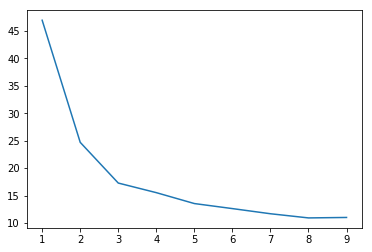

In [94]:
plt.plot(K,sum_of_square_distances)
print("Best k value=7")

In [96]:
merged = grouped

# add clustering labels
merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

merged.head() # check the last columns!

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,Latin American Restaurant,Skating Rink,Breakfast Spot,Lounge,Yoga Studio,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,Pizza Place,Pharmacy,Sandwich Place,Dance Studio,Coffee Shop,Pub,Gym,Airport Terminal,College Stadium,Event Space
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,Coffee Shop,Bank,Mobile Phone Shop,Fried Chicken Joint,Bridal Shop,Sandwich Place,Diner,Deli / Bodega,Restaurant,Middle Eastern Restaurant
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,Café,Bank,Japanese Restaurant,Chinese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,...,Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Hobby Shop,Pharmacy,Pizza Place,Pub,Café,Butcher
